# BSOC as a Convoultional Layer

This work is based on papers by Dr. Gabriel Ferrer from Hendrix College. I will explore the practicality of using Bounded Self-Organizing Clusters (BSOC) as a way to create the first convoultional in a convoultional network. I will be using Pytorch as a baseline in this notebook.

## Data:
The data comes from pictures taken on a Galaxy S8 at 1280x720px.
### 7/9/2018
Room: 10 Pictures <br/>
Kitchen: 10 Pictures

## 1: Defining Our Heaps and BSOCs

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import heapq as hq

## Let's write a wrapper around heapq to help keep us sane.
## this heap needs to let us remove an arbitrary amount of edges

class Heap():
    def __init__(self):
        self.list = []
    def add(self, item, priority=0):
        hq.heappush(self.list, (priority, item))
    def add_many(self, entries_list, entries_priorities):
        self.list += [li for li in zip(entries_priorities, entries)]
        hq.heapify(self.list)
    def pop(self):
        return hq.heappop(self.list)
    def filter_f(self, filter_func):
        self.list = list(filter(filter_func, self.list))
        hq.heapify(self.list)
    def remove_many(self, entries):
        set_check = set(entries)
        self.list = [(p,e) for p,e in self.list if e not in set_check]
        hq.heapify(self.list)
        ## we do this because it is faster to create a new list rather than modify a ton of items in a list
        ## Todo, check if this is faster than a for loop to remove each item from a list.
    def __remove_1(self, entry):
        i_to_remove = -1;
        for i in range(len(self.list)):
            p,e = self.list[i]
            if e == entry:
                i_to_remove = i
        if i_to_remove == -1:
            raise ValueError("Could not find entry in heap")
        del self.list[i_to_remove]
    
    def remove_any_instance_of(self, i):
        self.list = [(p,e) for (p,e) in self.list if (e.a != i and e.b != i)]
        hq.heapify(self.list)
    def remove(self, entry):
        self.__remove_1(entry)
        hq.heapify(self.list)
    def remove_many_inplace(self, entries):
        for e in entries:
            self.__remove_1(e)
        
    
        
## Let's also just name our edges
class Edge():
    def __init__(self, a, b, weight):
        self.a = a
        self.b = b
        self.weight = weight
    def __eq__(self, other):
#         print(type(self.a))
#         print(type(self.b))
        return other.contains(self.a) and other.contains(self.b) and other.weight == self.weight

    def __lt__(self, other):
        return self.weight < other.weight
    
    def __le__(self, other):
        return self.weight <= other.weight
    
    def __gt__(self, other):
        return self.weight > other.weight
    
    def __ge__(self, other):
        return self.weight >= other.weight
    
    def __repr__(self):
        return str(self.a.ID) + " " + str(self.b.ID) + " " + str(self.weight)
    ## checks if a or b is c
    def contains(self, c):
        t1 = self.a == c
        t2 = self.b == c
        return t1 or t2
        
        

# Defining BSOC

In [2]:
class BSOC_Image_Node():
    def __init__(self, node_height, node_width, node_channels, ID = -1,  merge_count = 1, array=None):
        self.height = node_height
        self.width = node_width
        self.channels = node_channels
        self.ID = ID
        
        if array is None:
            self.array = np.zeros(shape=(node_height, node_width, node_channels))
        else :
            self.array = array
        self.merge_count = merge_count
    
    ## Returns a new node of this node and the other node merged together
    ## merge_f(node1, node2) returns new node. 
    def merge(self, other_node, new_ID, merge_func = None):
        if merge_func == None:
            ## default merge
            newCount = self.merge_count + other_node.merge_count
            a1 = self.array
            a2 = other_node.array
            r1 = self.merge_count / newCount
            r2 = other_node.merge_count / newCount
            a3 = (a1 * r1) + (a2 * r2)
            return BSOC_Image_Node(self.height, self.width, self.channels, ID=new_ID, merge_count = newCount, array=a3)
        return merge_func(self, other_node)
    
    def __eq__(self, other):
        return other.ID == self.ID
#         return np.array_equal(self.array, other.array) and self.merge_count == other.merge_count
    def __repr__(self):
        return self.array.__repr__()
        
    def calculate_distance(self, other):
        return (self.merge_count + other.merge_count) * np.sum(np.absolute(self.array - other.array))
        
        
        
class BSOC():
    def __init__(self, nodes_count, node_channels=1):
        self.total_nodes = nodes_count
        self.node_channels = node_channels
        self.node_list = []
        self.pq = Heap()
        self.generator = self.__default_generator()
        
    def __default_generator(self):
        i = 0
        while True:
            yield i
            i += 1
    def next_ID(self):
        return next(self.generator)
    ## if we're below the node threshold, then place the pixel array into the numpy list, 
    def add_node(self, pixel_arr):
        node = BSOC_Image_Node(pixel_arr.shape[0], pixel_arr.shape[1], pixel_arr.shape[2], ID=self.next_ID(), array=pixel_arr)
        ## Add the node to the priority queue. 
        self.add_node_and_edges(node)
        if len(self.node_list) > self.total_nodes:
            weight, e = self.pq.pop()
            self.node_list = [x for x in self.node_list if x not in (e.a, e.b) ] ## deletes a and b from the list
            self.pq.remove_any_instance_of(e.a)
            self.pq.remove_any_instance_of(e.b)
            self.__merge(e.a, e.b)

            
                    
    def add_node_and_edges(self, node):
        for n in self.node_list:
            e = Edge(node, n, weight=n.calculate_distance(node))
            self.pq.add(e, e.weight)
        self.node_list.append(node)

    ## merges nodes a and b and adds their respective edges to the priority queue
    ## merge_func = function to merge together the nodes at the indeces
    def __merge(self, a, b, merge_func=None):
        new_node = a.merge(b, self.next_ID(), merge_func)
        self.add_node_and_edges(new_node)

        
    ## Only works on raw images, if converted to tensors or loaded from pytorch default libraries, it won't show
    def print_bsoc(self, ncols=-1, nrows=1):
        if ncols * nrows < len(self.node_list):
            ncols = len(self.node_list)
        fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 10))
        print(len(self.node_list))
            
        for i in range(len(self.node_list)):
            a = axeslist.ravel()[i]
            a.imshow(self.node_list[i].array.astype(np.int64))
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
            a.set_title('Merged {}x {}'.format(self.node_list[i].merge_count, self.node_list[i].ID))
            

# BSOC Test

We need to verify that we correctly implemented BSOC, so let's see the output of combining a few images together

## Loading data

In [3]:
# Get out data files
import os

## Creating a base class for our dataset
from torch.utils.data import Dataset
from PIL import Image

class simpleImageDataset(Dataset):
    """ Loads images, it assumes that the folder in which the file is stored is the label """
    
    def __init__(self, directory, transform=None):
        self.label_to_ind_dict = {}
        self.ind_to_label = {}
        self.labels = []
        self.file_paths = []
        self.transform = transform
        self.label_count = 0
        for dirpath, dirname, filenames in os.walk(directory):
            for file in filenames:
                label = dirpath.split(os.sep)[-1]
                if label not in self.label_to_ind_dict:
                    self.label_to_ind_dict[label] = self.label_count
                    self.ind_to_label[self.label_count] = label
                    self.label_count += 1
                self.labels.append(dirpath.split(os.sep)[-1])
                self.file_paths.append(os.path.join(dirpath, file))
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx])
        label = self.labels[idx]
        sample = {'image':image}
        
        if self.transform:
            sample = {'image': self.transform(image)}
        return sample
    def label_for(self, idx):
        return self.labels[idx]
    def label_tensor(self, idx):
        return torch.Tensor([self.label_to_ind_dict[self.label_for(idx)], self.label_count])

## Viewing our Data
room_dataset = simpleImageDataset("./Data", transform=transforms.Compose([transforms.Resize((72,128))]))

In [4]:
import time

## Generates kernels_count kernels of kernel_size from dataset 
def generate_kernels(kernels_count, kernel_size, dataset):
    start_time = time.time() * 1000
    bsoc = BSOC(nodes_count=kernels_count)
    offset = (kernel_size // 2) * 2
    for i,data in enumerate(dataset, 0):
#     for i in range(1):
        image = data[0].numpy()
        ## Iterate through the image
        for r in range(len(image[1]) - offset):
            r_stop = r + kernel_size
            for c in range(len(image[2]) - offset):
                bsoc.add_node(image[:,r:r_stop, c:c+kernel_size])
    print("Total time in milli: " + str(time.time()*1000 - start_time))
    return bsoc

## BSOC using Test Data

We make sure BSOC appears to cluster correctly using the following

10


[37, 40, 37, 36, 35, 33, 39, 38, 42, 63]

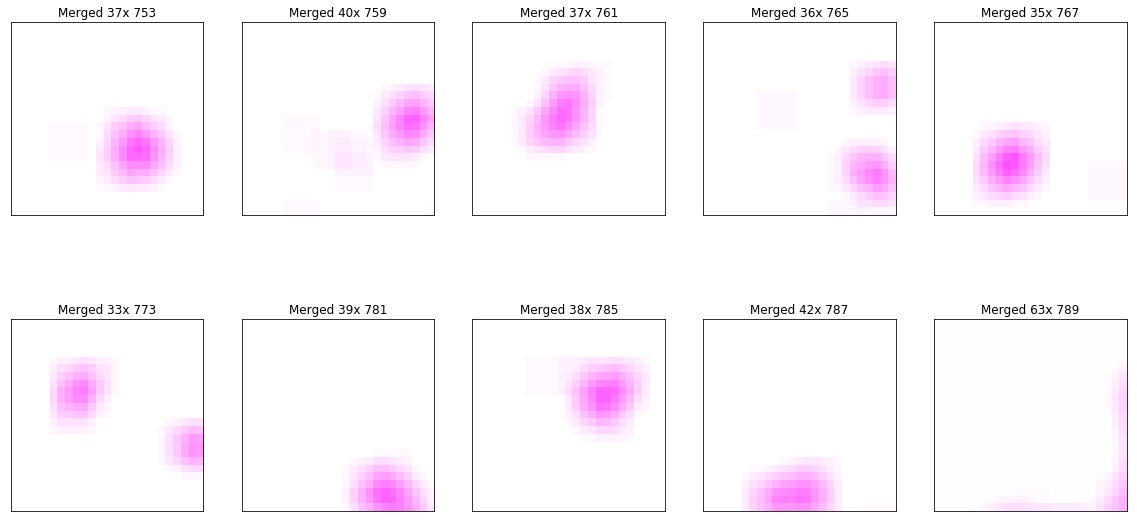

In [5]:
test_dataset = simpleImageDataset("./test_data/")
bsoc = BSOC(nodes_count=10)

for i in range(len(test_dataset)):
    bsoc.add_node(np.array(test_dataset[i]['image']))
bsoc.print_bsoc(nrows=2, ncols=5)
[x.merge_count for x in bsoc.node_list]


We see that it reasonably works, now let's test it on our room data by loading the data using the built in functions and resizing the images to 72x128px images

In [6]:
room_dataset2 = torchvision.datasets.ImageFolder(root="./Data",transform=transforms.Compose([transforms.Resize((72,128)),
                                                                                    transforms.ToTensor()]))

roomLoader = torch.utils.data.DataLoader(room_dataset2,batch_size=20,
                                          shuffle=False, num_workers=2)

In [7]:
bsoc = generate_kernels(10, 5, room_dataset2)

Total time in milli: 35476.592529296875


In [8]:
kernels = [x.array for x in bsoc.node_list]
kernels = torch.from_numpy(np.array(kernels))
kernels.shape

torch.Size([10, 3, 5, 5])

In [29]:
import torch.nn as nn
import torch.nn.functional as F
import queue



class BSOCNet(nn.Module):
    def __init__(self):
        super(BSOCNet, self).__init__()
        ## These dimensions are because there are 10 kernels, we lose 4 on the other dimensions (from 72, 128) 
        ## Because we are not padding, we are losing 2 on each side of the image. 
        self.fc = nn.Linear(10 * 68 * 124, 2)
        
    def forward(self, x):
        x = F.conv2d(x, kernels, padding=0, stride=1)
        x = x.view(-1, 10*68*124)
        x = self.fc(x)
        return x
        
net = BSOCNet()

Now with our network defined (with the Convolutional network as a template, not benchmark). Let's see if we train using our 20 images repeated 40 times if our network can learn!

In [39]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [40]:
for epoch in range(10):  # loop over the dataset multiple times
#     running_loss = 0.0
    for i, data in enumerate(roomLoader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
#         running_loss += loss.item()
#         print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
print('Finished Training')

Finished Training


In [41]:
for i,data in enumerate(roomLoader, 0):
    inputs, labels = data
    output = net(inputs)
    for j in output.data:
        p = j.numpy()
        ind = np.where(p == max(p))[0][0]
        print(p)
        print(room_dataset2.classes[ind])
room_dataset2.classes

[ 3369.1519 -3372.0742]
Kitchen
[ 5926.7954 -5920.6816]
Kitchen
[ 5474.402  -5466.0522]
Kitchen
[ 4416.003  -4411.0635]
Kitchen
[ 7963.2197 -7958.658 ]
Kitchen
[-876.7017   886.81067]
Room
[ 5500.0884 -5493.6187]
Kitchen
[ 1019.215  -1016.8297]
Kitchen
[ 12823.803 -12815.991]
Kitchen
[ 5476.551 -5467.156]
Kitchen
[-6433.575   6441.9175]
Room
[-2642.958  2646.028]
Room
[ 1753.0742 -1752.0314]
Kitchen
[-7812.5522  7818.076 ]
Room
[-5951.856  5960.973]
Room
[-10553.076  10557.705]
Room
[-13388.41   13393.963]
Room
[-14854.46   14854.911]
Room
[-20619.225  20622.531]
Room
[-17260.115  17257.422]
Room


['Kitchen', 'Room']

Classification is done by taking the maximum value of the outputs. therefore, we see that in our inorder data, we have classified the first 10 images as Kitchen, and 9 (or 10, depending on trial and luck) out of 10 of the remainig images as Room. Of course, we expect good results because of the smalll sample size and the fact that we are testing on our training data.

In [44]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.fc1 = nn.Linear(10 * 68 * 124, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10 * 68 * 124)
        x = self.fc1(x)
        return x
net2 = ConvNet()

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times
#     running_loss = 0.0
    for i, data in enumerate(roomLoader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [46]:
for i,data in enumerate(roomLoader, 0):
    inputs, labels = data
    output = net2(inputs)
    for j in output.data:
        p = j.numpy()
        ind = np.where(p == max(p))[0][0]
        print(p)
        print(room_dataset2.classes[ind])
room_dataset2.classes

[ 1.1426086  -0.90841144]
Kitchen
[ 1.1698337 -1.0974243]
Kitchen
[ 1.2155966 -0.9470705]
Kitchen
[0.14495961 0.2881697 ]
Room
[ 1.4272242 -1.061355 ]
Kitchen
[0.33529133 0.03132847]
Kitchen
[ 0.66311187 -0.48263606]
Kitchen
[ 0.43383834 -0.23321143]
Kitchen
[ 1.7784904 -1.333925 ]
Kitchen
[ 1.2260749  -0.84163505]
Kitchen
[-0.7140519  1.00108  ]
Room
[-0.08620625  0.35013425]
Room
[ 0.6629934 -0.2916848]
Kitchen
[-1.3223685  1.6481109]
Room
[-0.8564104  1.1311259]
Room
[-1.6083596  1.8339676]
Room
[-1.7706617  2.0158775]
Room
[-1.7566941  2.1005387]
Room
[-1.8811066  2.0436385]
Room
[-1.6791734  1.855024 ]
Room


['Kitchen', 'Room']

This is a neat result because we see that our Convoultional network falsely classifies a lot more than our fixed one. We know this because we expect the first 10 to be Kitchen and the last 10 to be Room since this is how we trained it. I was expecting equal performance to the BSOC

In [49]:
kernels_rand = torch.randn(10,3,5,5)
class ConvNetFixedKernels(nn.Module):
    def __init__(self):
        super(ConvNetFixedKernels, self).__init__()
        self.fc = nn.Linear(10 * 68 * 124, 2)
        
    def forward(self, x):
        x = F.conv2d(x, kernels_rand, padding=0, stride=1)
        x = x.view(-1, 10 * 68 * 124)
        x = self.fc(x)
        return x
net3 = ConvNetFixedKernels()

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times
#     running_loss = 0.0
    for i, data in enumerate(roomLoader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [51]:
for i,data in enumerate(roomLoader, 0):
    inputs, labels = data
    output = net3(inputs)
    for j in output.data:
        p = j.numpy()
        ind = np.where(p == max(p))[0][0]
        print(p)
        print(room_dataset2.classes[ind])

[  8.574949 -11.713362]
Kitchen
[ 39.927414 -43.628204]
Kitchen
[ 20.00264  -24.587425]
Kitchen
[ 54.078552 -57.163506]
Kitchen
[  97.59509 -103.39204]
Kitchen
[-38.226208  32.126045]
Room
[ 70.26821  -74.150345]
Kitchen
[ 11.590749 -14.532576]
Kitchen
[ 174.35808 -179.68974]
Kitchen
[ 73.182945 -77.34572 ]
Kitchen
[-105.09409  100.46385]
Room
[-80.87271  77.49111]
Room
[-86.66643  82.23345]
Room
[-179.72525  174.69305]
Room
[-127.36094  121.67215]
Room
[-210.19641  205.38268]
Room
[-261.60257  255.47517]
Room
[-254.55688  251.16011]
Room
[-292.3463  290.0814]
Room
[-287.8599   284.37006]
Room


Look at this result, we see that our randomly made fixed kernels network are a lot worse than our BSOCs! This tells us that pre-seeding a convoultional network will give us faster training (in our specific case of 20 images repeated 40 times using the specific images we have here)! This gives promising results and could potentially mean that we can more quickly train neural nets simply passing our images through a BSOC. There are obviously questions and future work available: 
* Will this still work when we increase the train and test data?
* What is performance when not testing on training data?
* Will dynamically changing BSOCs instead of statically generated before hand be better?
* To what extent will altering the number of BSOC nodes and kernels change performance?

I did not create bsocs which train as we go because of the nature of my implementation of BSOC. Because I remove both of the closest nodes and re add them to the node list, the order of nodes shifts all the time.

# Questions from Dr. Ferrer
* How do people define convolutional layers initially besides random. 
* <s>ConvNet with fixed kernels and without (no back propagation)</s>
* <s>ConvNet without fixed kernels (Normal)</s>
* <s>BSOCNet with Fixed kernels (Hypothesis)</s>
* BSOCNet with without fixed kernels. 
* how are the convolutional network weights back propagated?
* <s>Generate test images with squares in them to see if bsoc works correctly</s>